# 屈折を考慮して、見かけの位置でGaussianを移動させ、レンダリングする


In [3]:
import os
import torch
import numpy as np
from plyfile import PlyData
from gsplat import rasterization
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

import sys
sys.path.append('..')  # Adjust the path as necessary to locate the 'mine' module
from mine.read_transformers import readNerfSyntheticCameras, fov2focal
from pathlib import Path

nerf_dataset_path = os.path.abspath(os.path.join("..", "data", "transformers"))

train_cams, test_cams = readNerfSyntheticCameras(nerf_dataset_path, white_background=True, extension=".png", eval_mode=True)

print(len(train_cams), "training cameras")
print(len(test_cams), "test cameras")

# 例: 取り出し
for cam in train_cams[:1]:
    print("uid=", cam.uid)
    print("R=", cam.R)
    print("T=", cam.T)
    print("FovX(deg)=", np.degrees(cam.FovX))
    print("FovY(deg)=", np.degrees(cam.FovY))
    print("image_name=", cam.image_name)
    print("image size=", (cam.width, cam.height))
    print("---")


Reading Training Transforms...
64 training cameras
0 test cameras
uid= 0
R= [[ 1. -0. -0.]
 [ 0. -1. -0.]
 [ 0. -0. -1.]]
T= [ 16.804981 -16.804981  20.      ]
FovX(deg)= 39.597755335771296
FovY(deg)= 39.597755335771296
image_name= 0000
image size= (1600, 1600)
---


In [8]:
# path of ply file
file_path = os.path.abspath(os.path.join(os.path.expanduser("~"), "OneDrive", "3d_map_data", "20250318_simple_river_wo_surface_COS", "result", "transformers_20250318-173258", "ply", "point_cloud_29999.ply"))

from mine.loader import initialize_model_from_ply_file
# get Gaussian model from ply file
device = torch.device("cuda:0")
gs_model = initialize_model_from_ply_file(file_path, device=device)

In [9]:
gs_model

VanillaGaussianModel(
  (gaussians): ParameterDict(
      (means): Parameter containing: [torch.cuda.FloatTensor of size 1000000x3 (cuda:0)]
      (opacities): Parameter containing: [torch.cuda.FloatTensor of size 1000000x1 (cuda:0)]
      (scales): Parameter containing: [torch.cuda.FloatTensor of size 1000000x3 (cuda:0)]
      (rotations): Parameter containing: [torch.cuda.FloatTensor of size 1000000x4 (cuda:0)]
      (shs): Parameter containing: [torch.cuda.FloatTensor of size 1000000x16x3 (cuda:0)]
  )
)

In [10]:
# get each parameters as tensor from Gaussian model  torch.from_numpy
means     = gs_model.gaussians["means"]      # shape: [N, 3]
scales    = gs_model.gaussians["scales"]     # shape: [N, 3]
quats     = gs_model.gaussians["rotations"]  # shape: [N, 4]
opacities = gs_model.gaussians["opacities"].squeeze(-1)   # shape: (N,)
colors    = gs_model.gaussians["shs"]        # shape: [N, 16, 3]



# Refractionを考慮して座標変換

In [5]:
from torch import Tensor 

def transform_to_refraction(
    gs_means: Tensor, # [N,3]
    cam_center: np.array, # [3,]
    refraction_surface_z = 0 
) -> Tensor:
    '''
    見かけの位置にGaussianの中心を座標変換
    Input: Camera Center
           means: Tensor[N, 3]
    Output: means: Tensor[N, 3]
    '''
    
    cam_center_tensor = torch.Tensor(cam_center)
    
    
    

In [ ]:
import numpy as np

def solve_intersection_quartic_equation(
    gs_mean: Tensor, # [N,3]
    cam_center, # [N,3]
):
    x = gs_mean[0]
    y = gs_mean[1]
    h = gs_mean[2]
    
    r = x**2 + y**2
    
    
    return None


n = 1.33  # refraction ratio 
pl = 0    # water surface (z = pl) 
H = 10    # camera distance


gs_mean = means[0]



# real position of Gaussian's center under water
x = gs_mean[0].to('cpu').detach().numpy()
y = gs_mean[1].to('cpu').detach().numpy()
h = gs_mean[2].to('cpu').detach().numpy() - pl # (<0) depth because we estimate the water surface is z = 0


# geometric distance and angle
r2 = x**2 + y**2
r = np.sqrt(r2)  # dimeter from z axis to the gaussian center

n2 = n**2
H2 = H**2

# expand the Snell's Law by s, where distance the vetical line to the intersection of ray
a_4 = 1 - n2
a_3 = 2*r * (n2-1)
a_2 = h**2 + (1-n2)*r2 - n2*H2
a_1 = 2*n2*r*H2
a_0 = - H2*n2*r2

roots = np.roots([a_4, a_3, a_2, a_1, a_0])  






In [ ]:
# 0番目カメラを取り出す
cam = train_cams[30]
width, height = cam.width//4, cam.height//4
# width, height = cam.width//2, cam.height//2
# width, height = cam.width, cam.height

# f_x, f_y を計算
f_x = fov2focal(cam.FovX, width)   # 横幅に対する焦点距離
f_y = fov2focal(cam.FovY, height)  # 縦幅に対する焦点距離

# 光学中心 cx, cy (画像中心と仮定)
cx = width  / 2.0
cy = height / 2.0

# Intrinsics 行列
K = np.array([
    [f_x,   0,   cx],
    [  0, f_y,   cy],
    [  0,   0,   1 ]
], dtype=np.float32)

print("K =\n", K)
# 4x4 のワールド→カメラ変換 (Extrinsic) を作る
W2C = np.eye(4, dtype=np.float32)
W2C[:3, :3] = cam.R  # cam.R はすでに転置済みの場合あり; それは readNerfSyntheticInfo の仕様
W2C[:3,  3] = cam.T

print("W2C =\n", W2C)

# ライブラリに合った形に reshape/unsqueeze するなど
viewmats = torch.from_numpy(W2C)[None, :, :].to(device)  # 1カメラ分の4x4行列をCUDAへ
Ks       = torch.from_numpy(K)[None, :, :].to(device) # 1カメラ分の3x3行列をCUDAへ

K =
 [[555.55554   0.      200.     ]
 [  0.      555.55554 200.     ]
 [  0.        0.        1.     ]]
W2C =
 [[ 1.        -0.        -0.        -4.2012453]
 [ 0.        -1.        -0.         8.402491 ]
 [ 0.        -0.        -1.        20.       ]
 [ 0.         0.         0.         1.       ]]


In [ ]:
# render
rgb_image, alpha, metadata = rasterization(
    means,
    quats,
    scales,
    opacities,
    colors,
    viewmats,
    Ks,
    width,
    height,
    sh_degree=3,
    rasterize_mode="antialiased"
)

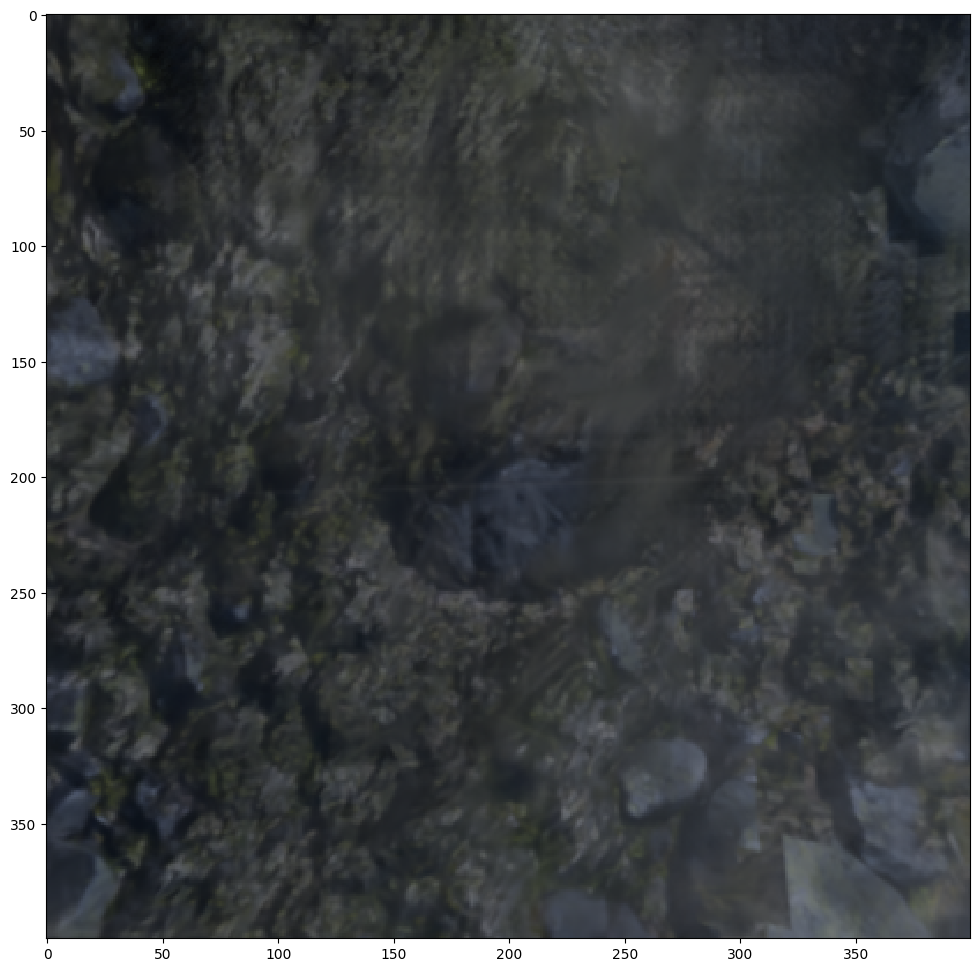

In [ ]:
# Display the rendered image.
display_image = rgb_image.squeeze().cpu().detach().numpy()
plt.imshow(display_image)
# plt.axis("off")
